In [1]:
import os

import pandas as pd
import numpy as np

import scipy.stats as ss
import statsmodels.api as sm

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

from compute_correlations import compute_pearson_correlation, compute_kendall_correlation
from graphs import build_full_graph, build_threshold_graph, find_max_clique, find_max_independent_set

In [2]:
RESULTS_DIR = 'analysis_images'
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)

# Отрисовка гистограм температуры

In [3]:
def load_temp_by_season_interval(season, interval):
    cities = ["msk", "spb", "kaz", "ufa", "nn", "novosib", "vlad"]
    df = pd.DataFrame(columns=cities)
    for city in cities:
        df[city] = pd.read_csv(f"result_datasets/{city}_df_{season}_{interval}.csv")["T"]
    return df

In [4]:
winter_df = load_temp_by_season_interval('winter', '3h')
spring_df = load_temp_by_season_interval('spring', '3h')
summer_df = load_temp_by_season_interval('summer', '3h')
autumn_df = load_temp_by_season_interval('autumn', '3h')

In [5]:
winter_df['Сезон'] = 'Зима'
spring_df['Сезон'] = 'Весна'
summer_df['Сезон'] = 'Лето'
autumn_df['Сезон'] = 'Осень' 

combined_df = pd.concat([winter_df, spring_df, summer_df, autumn_df])
melted_df = combined_df.melt(id_vars=['Сезон'], var_name='City', value_name='Temperature')

In [6]:
colors_by_season = {
    'Зима' : 'lightblue',
    'Весна' : 'pink',
    'Лето' : 'yellowgreen',
    'Осень': 'orange'
}

city_names = {
    'msk': 'Москва',
    'spb': 'Санкт-Петербург',
    'kaz': 'Казань',
    'ufa': 'Уфа',
    'nn': 'Нижний Новгород',
    'novosib': 'Новосибирск',
    'vlad': 'Владивосток'
}
melted_df['City'] = melted_df['City'].map(city_names)

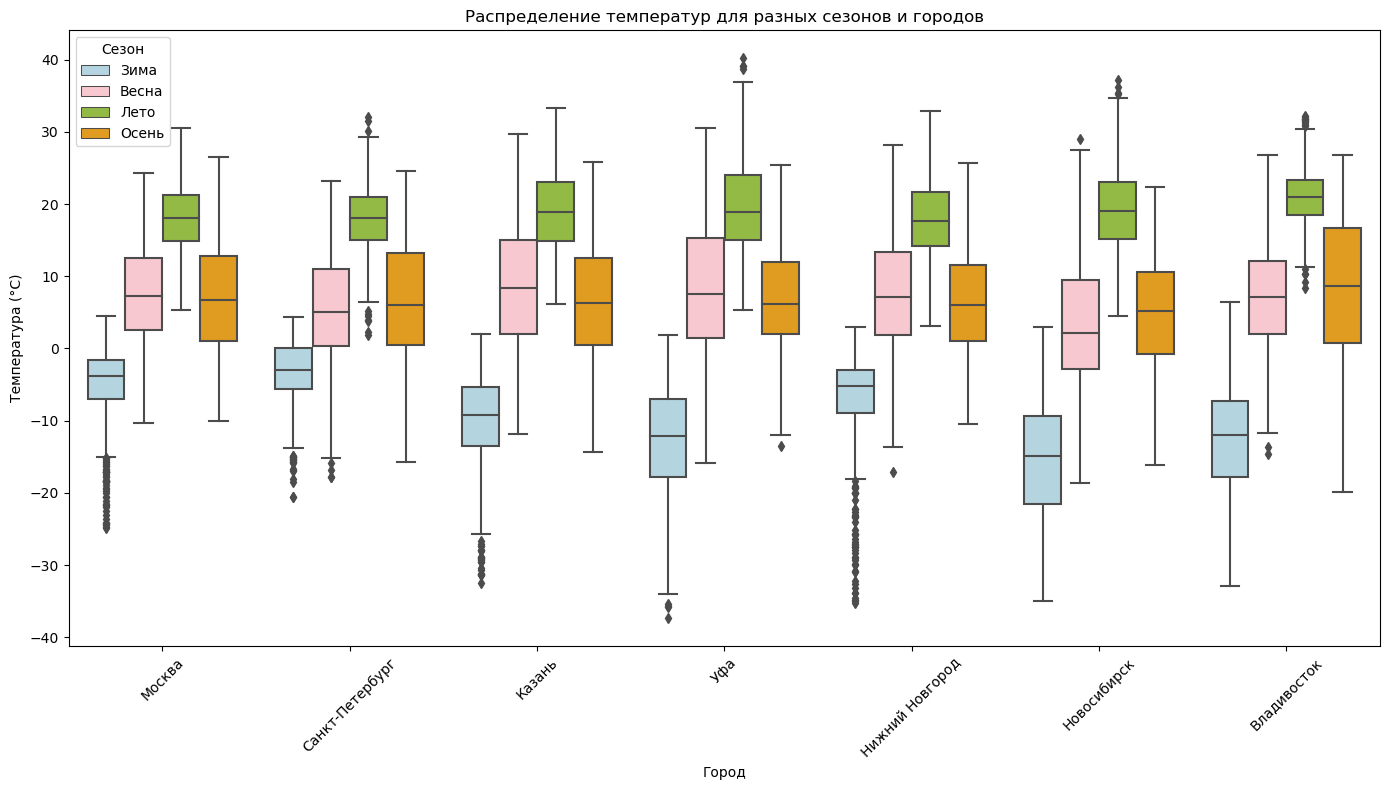

<Figure size 640x480 with 0 Axes>

In [7]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=melted_df, x='City', y='Temperature', hue='Сезон', palette=colors_by_season)

plt.title('Распределение температур для разных сезонов и городов')
plt.xlabel('Город')
plt.ylabel('Температура (°C)')
plt.legend(title='Сезон')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
plt.savefig(f'boxplot_общий.png', dpi=300)

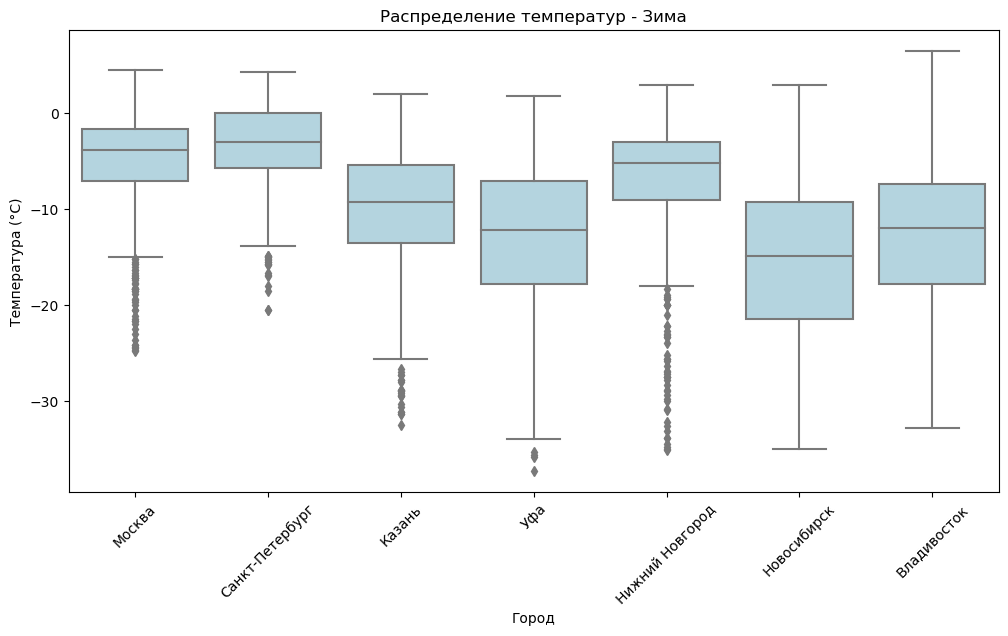

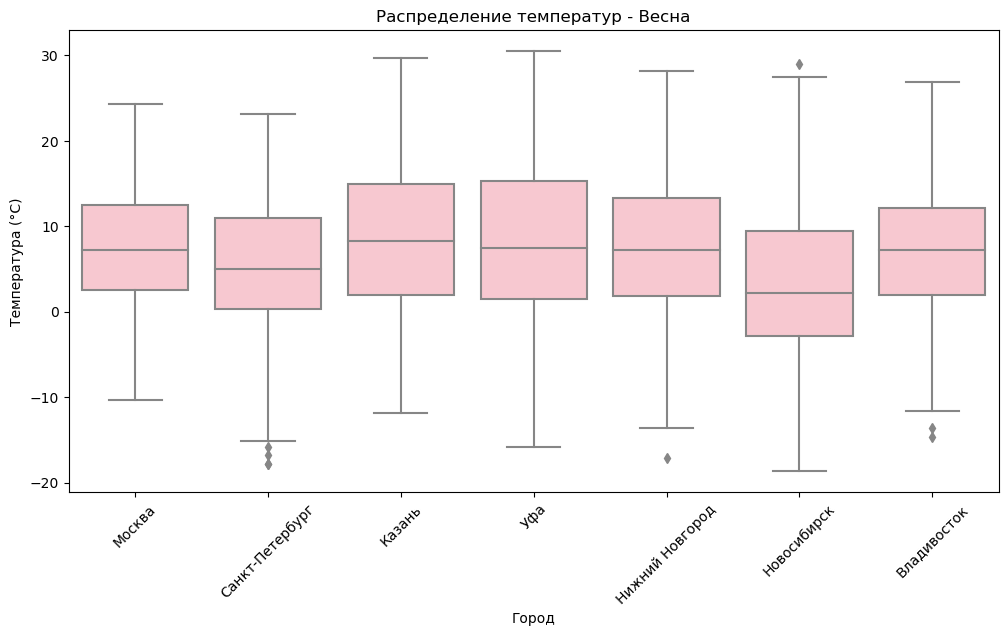

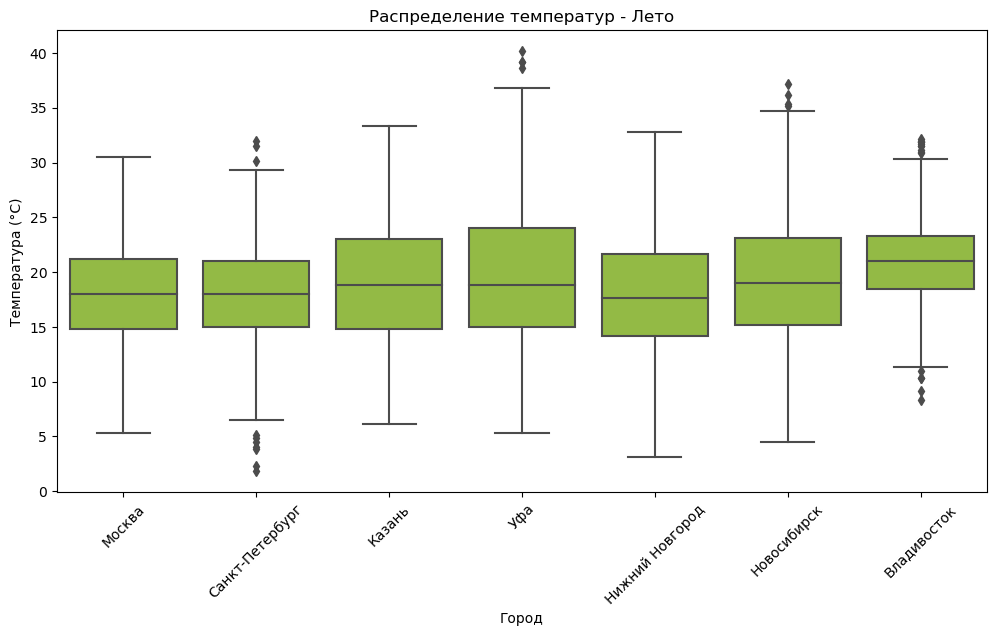

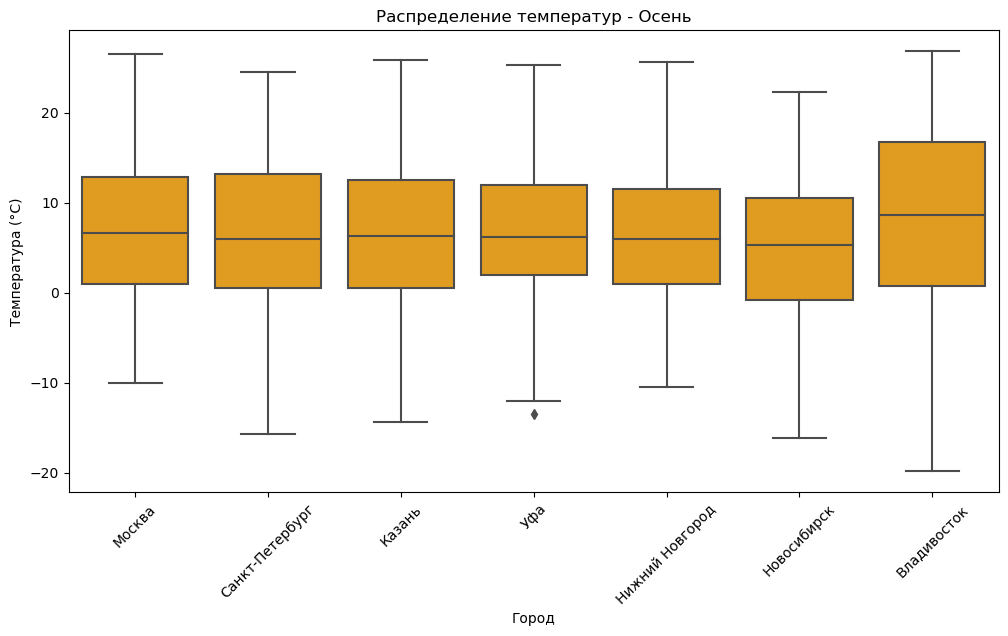

In [8]:
for season, color in colors_by_season.items():

    plt.figure(figsize=(12, 6))
    season_data = melted_df[melted_df['Сезон'] == season]
    sns.boxplot(data=season_data, x='City', y='Temperature', color=color)
    
    plt.title(f'Распределение температур - {season}')
    plt.xlabel('Город')
    plt.ylabel('Температура (°C)')
    plt.xticks(rotation=45)
    
    plt.show()

    # plt.savefig(f'boxplot_{season.lower()}.png')
    # plt.close()

# Анализ зависимости между корреляциями Пирсона и Кендалла

рассматриваем все данные (по 4 сезонам) для различных интервалов наблюдения

In [9]:
df_3h = pd.concat([
    load_temp_by_season_interval('winter', '3h'), 
    load_temp_by_season_interval('spring', '3h'), 
    load_temp_by_season_interval('summer', '3h'), 
    load_temp_by_season_interval('autumn', '3h')
])

df_daily = pd.concat([
    load_temp_by_season_interval('winter', 'daily'), 
    load_temp_by_season_interval('spring', 'daily'), 
    load_temp_by_season_interval('summer', 'daily'), 
    load_temp_by_season_interval('autumn', 'daily')
])

df_weekly = pd.concat([
    load_temp_by_season_interval('winter', 'weekly'), 
    load_temp_by_season_interval('spring', 'weekly'), 
    load_temp_by_season_interval('summer', 'weekly'), 
    load_temp_by_season_interval('autumn', 'weekly')
])

In [10]:
cities = ['msk', 'spb', 'kaz', 'ufa', 'nn', 'novosib', 'vlad']

In [11]:
def analyze_corr(dfs, interval_names):

    plt.figure(figsize=(14, 8))

    colors = ['navy', 'orangered', 'yellowgreen']
    styles = {
        'pearson' : 'solid',
        'kendall' : 'dashed'
    }

    for i, (df, interval_name) in enumerate(zip(dfs, interval_names)):

        pearson_values = [
            compute_pearson_correlation(df)[(cities[i], cities[j])] 
            for i in range(7) 
            for j in range(i + 1, 7)
        ]
        kendall_values = [
            compute_kendall_correlation(df)[(cities[i], cities[j])] 
            for i in range(7) 
            for j in range(i + 1, 7)
        ]
    
        plt.plot(pearson_values, label=f'Пирсон, {interval_name}', color=colors[i], linestyle=styles['pearson'])
        plt.plot(kendall_values, label=f'Кендалл, {interval_name}', color=colors[i], linestyle=styles['kendall'])

        print(f'Результаты анализа для временного интервала {interval_name}')

        # cравниваем скореллированность метрик классическими тестами
        spearman_result = ss.spearmanr(pearson_values, kendall_values)
        print(f'тест Cпирмана: statistic = {spearman_result.statistic:.06f}, pvalue = {spearman_result.pvalue:.06f}')
        pearson_result = ss.pearsonr(pearson_values, kendall_values)
        print(f'тест Пирсона: statistic = {pearson_result.statistic:.06f}, pvalue = {pearson_result.pvalue:.06f}')

        # ищем линейную зависимость между корреляциями пирсона (r) и кендалла (\tau) линейной регрессией
        # r = beta + C * tau
        model = sm.OLS(pearson_values, sm.add_constant(kendall_values)).fit()
        beta, c = model.params
        print(f'Линейная зависимость между корреляцией Пирсона и Кендалла линейной регрессией: {beta=:.04f}, {c=:.04f}, R^2={model.rsquared:.06f}')
        print()

    plt.title(f'Сравнение корреляции Пирсона и Кендалла для различных городов')
    plt.xlabel('Номер пары городов')
    plt.ylabel('Значение корреляции')
    plt.xticks(range(21))
    plt.xlim(0, 20)
    plt.legend()
    plt.grid()
    plt.show()

Результаты анализа для временного интервала 3 часа
тест Cпирмана: statistic = 0.988312, pvalue = 0.000000
тест Пирсона: statistic = 0.989456, pvalue = 0.000000
Линейная зависимость между корреляцией Пирсона и Кендалла линейной регрессией: beta=0.3342, c=0.7559, R^2=0.979023

Результаты анализа для временного интервала 1 день
тест Cпирмана: statistic = 0.984416, pvalue = 0.000000
тест Пирсона: statistic = 0.981400, pvalue = 0.000000
Линейная зависимость между корреляцией Пирсона и Кендалла линейной регрессией: beta=0.4165, c=0.6544, R^2=0.963146

Результаты анализа для временного интервала 1 неделя
тест Cпирмана: statistic = 0.931774, pvalue = 0.000000
тест Пирсона: statistic = 0.953145, pvalue = 0.000000
Линейная зависимость между корреляцией Пирсона и Кендалла линейной регрессией: beta=0.5610, c=0.4785, R^2=0.908485



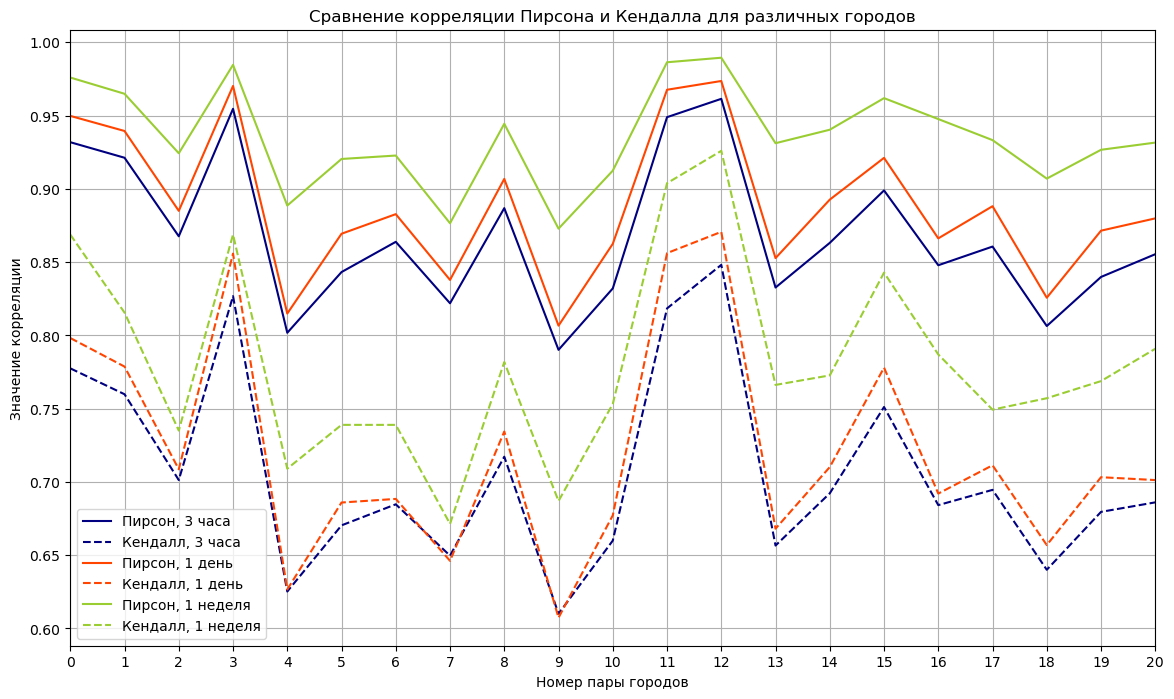

In [12]:
analyze_corr([df_3h, df_daily, df_weekly], interval_names=['3 часа', '1 день', '1 неделя'])

видим, что:
- для интервала в 3 часа `pearson = 0.3342 + 0.7559 * kendal`
- для интервала в 1 день `pearson = 0.4165 + 0.6544 * kendal`
- для интервала в 1 неделю `pearson = 0.5610 + 0.4785 * kendal`
  
со значением $R^2$ > 0.9

а для интервала в одну неделю такая зависимость не прослеживается